In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bifacial_geo as geo
import helper

from joblib import Parallel, delayed, Memory

In [2]:
def _run(df, distance, tilt, bifacial=True):
    simulator = geo.Simulator(df, bifacial=bifacial)
    return simulator.simulate(distance, tilt)

class ParallelWrapper():
    def __init__(self, location, cache=True):
        self.location = location
        self.df = helper.load_dataframe(self.location)
        self.cache = cache

    def parallel_run(self, distance_scan, tilt_scan, bifacial=True):
        if self.cache:
            cache_location = './cachedir'
            memory = Memory(cache_location, verbose=0)
            local_runner = memory.cache(_run)
        else:
            local_runner = _run

        return Parallel(n_jobs=4)(delayed(local_runner)\
                       (self.df, distance, tilt,  bifacial=True)
                       for distance in distance_scan
                       for tilt in tilt_scan)

def analyse_results_mean_agg(results):
    detailed_yield = results.groupby(level='contribution', axis=1).mean()\
                       .groupby(['distance','tilt']).sum()/1000

    direction = ['front' if 'front' in name else 'back'
                 for name in detailed_yield.columns]
    yearly_yield = detailed_yield.groupby(direction, axis=1).sum()
    yearly_yield['total'] = yearly_yield['front'] + yearly_yield['back']
    return yearly_yield

def analyse_results_min_agg(results):
    detailed_yield = results.groupby(level='contribution', axis=1).mean()\
                       .groupby(['distance','tilt']).sum()/1000

    direction = ['front' if 'front' in name else 'back'
                 for name in detailed_yield.columns]

    front_share = detailed_yield.groupby(direction, axis=1).sum()\
                                .eval('front/(front+back)')

    yearly_yield = results.groupby(level='module_position', axis=1).sum()\
                         .min(axis=1)\
                         .groupby(['distance', 'tilt']).sum()\
                         .rename('total').to_frame()
    yearly_yield['front'] = yearly_yield['total']*front_share
    yearly_yield['back'] = yearly_yield['total']-yearly_yield['front']
    return yearly_yield

def plot_heatmaps(stats):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi=100, figsize=(14,4))
    sns.heatmap(stats['total'].unstack('distance'), ax=ax1).set_title('total')
    sns.heatmap(stats['front'].unstack('distance'), ax=ax2).set_title('front')
    sns.heatmap(stats['back'].unstack('distance'), ax=ax3).set_title('back')
    plt.show()

def analyse_yield(location='dallas', grid='fine', optimize='min'):
    if grid == 'fine':
        if location == 'dallas':
            distance_scan = np.linspace(3,6,7)
            tilt_scan = np.linspace(22,38,9)
        if location == 'seattle':
            distance_scan = np.linspace(6,12,7)
            tilt_scan = np.linspace(26,48,12)

    if grid=='coarse':
        distance_scan = np.linspace(3,6,4)
        tilt_scan = np.linspace(1,61,7)

    wrapper = ParallelWrapper(location, cache=False)

    scan_results = wrapper.parallel_run(distance_scan, tilt_scan)

    mindex = pd.MultiIndex.from_product([distance_scan, tilt_scan],
                                    names=['distance', 'tilt'])

    scan_results = pd.concat(scan_results, keys=mindex, names=['distance', 'tilt'])

    stats = analyse_results_min_agg(scan_results)
    stats = stats/1000 #convert to kWh
    plot_heatmaps(stats)

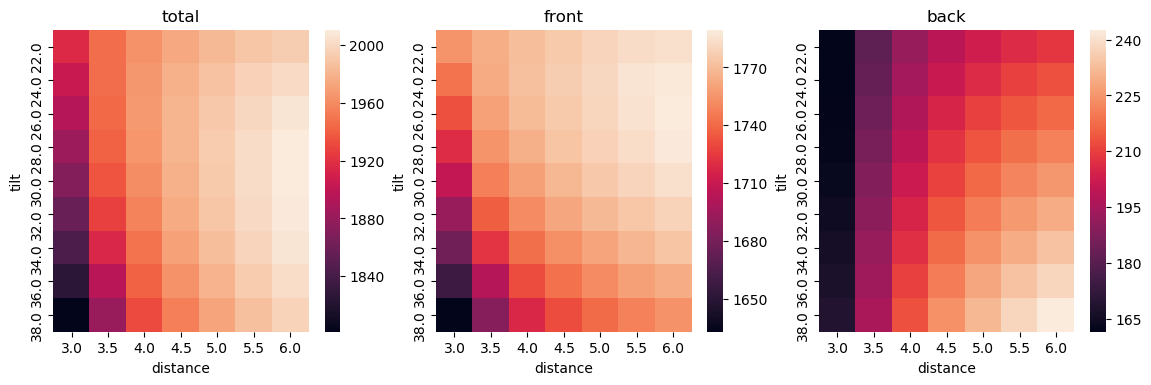

In [3]:
analyse_yield(location='dallas', grid='fine', optimize='min')

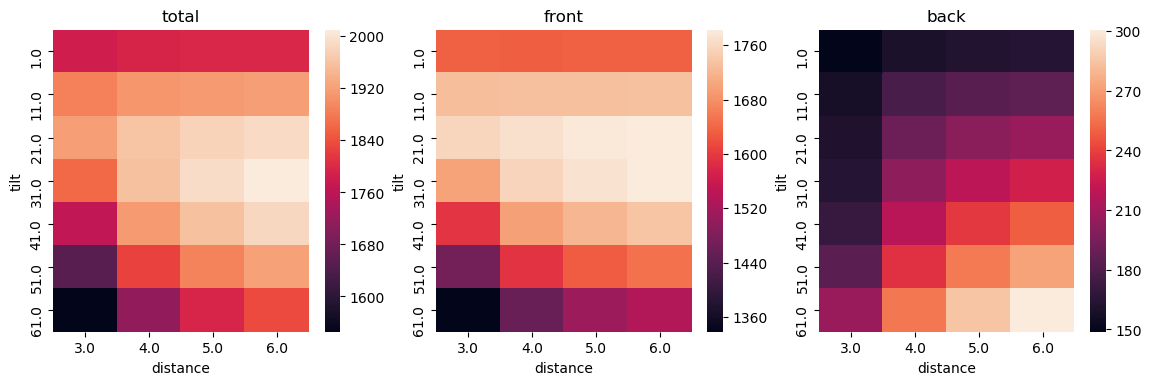

In [4]:
analyse_yield(location='dallas', grid='coarse', optimize='min')

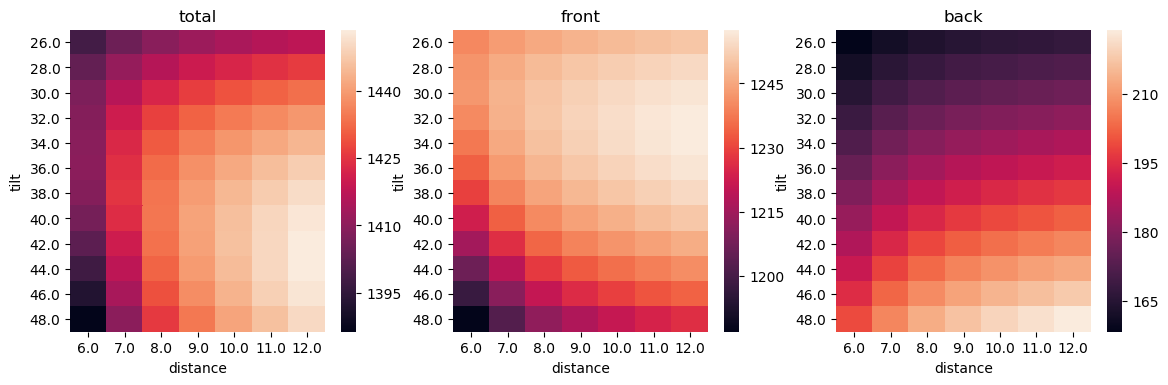

In [5]:
analyse_yield(location='seattle', grid='fine', optimize='min')

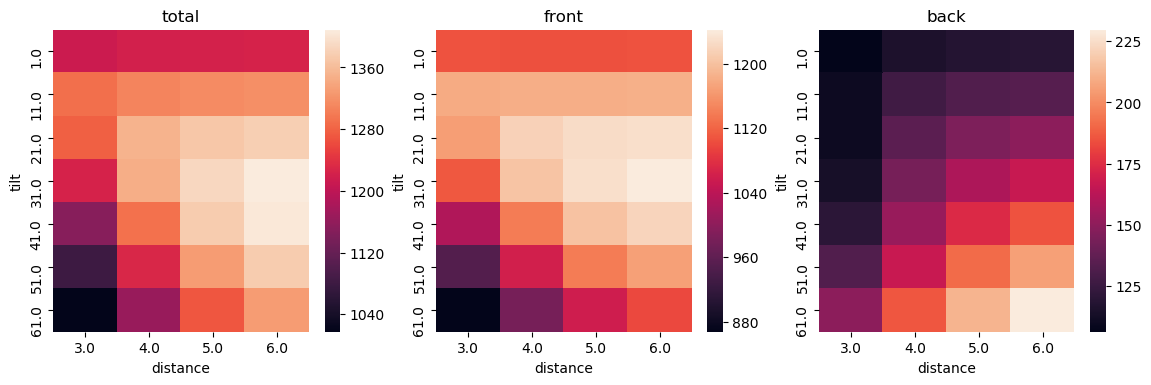

In [6]:
analyse_yield(location='seattle', grid='coarse', optimize='min')